# Deploying and Using matplotlib in Cloud Environments

## Table of Contents

* Introduction
  * Scenario
  * The data source

* Pre-cloud: figuring out the workflow
  * Organizing the data
  * Generating the images
  * The identified workflow
  * Selecting technologies
  * Planning for the next steps

* Getting set up at home
  * Requirements
  * Dockerfiles and Docker images
  * Extending a Docker image
    * Getting the base image
    * Customizing your Dockerfile
  * Buidling a new image
  * Preparing for deployment

* Getting set up on AWS
  * Pusing source data to S3
  * Creating a server on EC2
  * Using Docker on EC2
  * Reading and writing with S3

* Running the task
  * Using environment variables
  * Updating the image and EC2
  * Execution

Before we get started, let's do our usual warm-up proceedure:

In [1]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline

And imports:

In [2]:
from IPython.display import Image 

import sys
sys.path.append("../lib")
import eros

ImportError: No module named 'eros'

## Introduction

At first blush, it may seem odd that we are contemplating the distributed use of a library which has historically been focused on desktop-type environments. However, when pausing to ponder this more, one does see the value of it: you have probably noted that with large data sets or complex plots, matplotlib runs perhaps more slowly that we might like. What to do, then, when we need to generate a handful of plots for very large data sets or 1000s of plots from diverse sources?

If this sounds far-fetched, keep in mind that there are companies that have massive PDF-generating “farms” of servers for similar activities. This notebook will be exploring a similar use case: you are a researcher working for small company tracking climactic patterns and possible changes at both poles. Your team is focused on the Arctic, and your assignment is to process satellite imagery for the east coast of Greenland: not only the new images as they coming (every 16 days), but previously captured satellite data as well.

### Scenario

Imagine that you are a software engineer working for a research firm tracking climate data in various arctic regions. You've been tasked with processing data for [Scoresby Sund, Greenland](https://en.wikipedia.org/wiki/Scoresby_Sund) -- the largest and longest fjord system in the world. You will be using data from [Landsat 8](https://en.wikipedia.org/wiki/Landsat_8), processing both 1) satellite image data since its launch in 2013, and 2) new imagery as it comes in, [every 16 days](http://landsat.usgs.gov/landsat8.php). The data sets are fairly large, weighing in between 600 and 900 MB. We'll take a look at a sample workflow, and then propose a plan for handling this on a recurring basis.

We have based the code used in our ``eros`` module upon the BSD-licensed code that Milos Miljkovic provided for his PyData 2014 talk [Analyzing Satellite Images With Python Scientific Stack](https://github.com/HyperionAnalytics/PyDataNYC2014); we have, however, made a fair number changes -- all of which were so much easier to make thanks to Milos' work!

### The data source

For your project, you will be acquiring data from the [EROS](http://eros.usgs.gov/about-us) archives using the [USGS EarthExplorer site](http://earthexplorer.usgs.gov/) (downloads require a [registered user account](https://earthexplorer.usgs.gov/register/), which is free). You will use their map to locate what are called “scenes” – specific geographic areas of satellite imagery which can be downloaded using the EarthExplorer “Bulk Download Application”. Your initial focus will be data from Scoresby Sund, the largest and longest fjord system in the world.

Here is a view of the EarthExplorer site where you will search for your scenes:

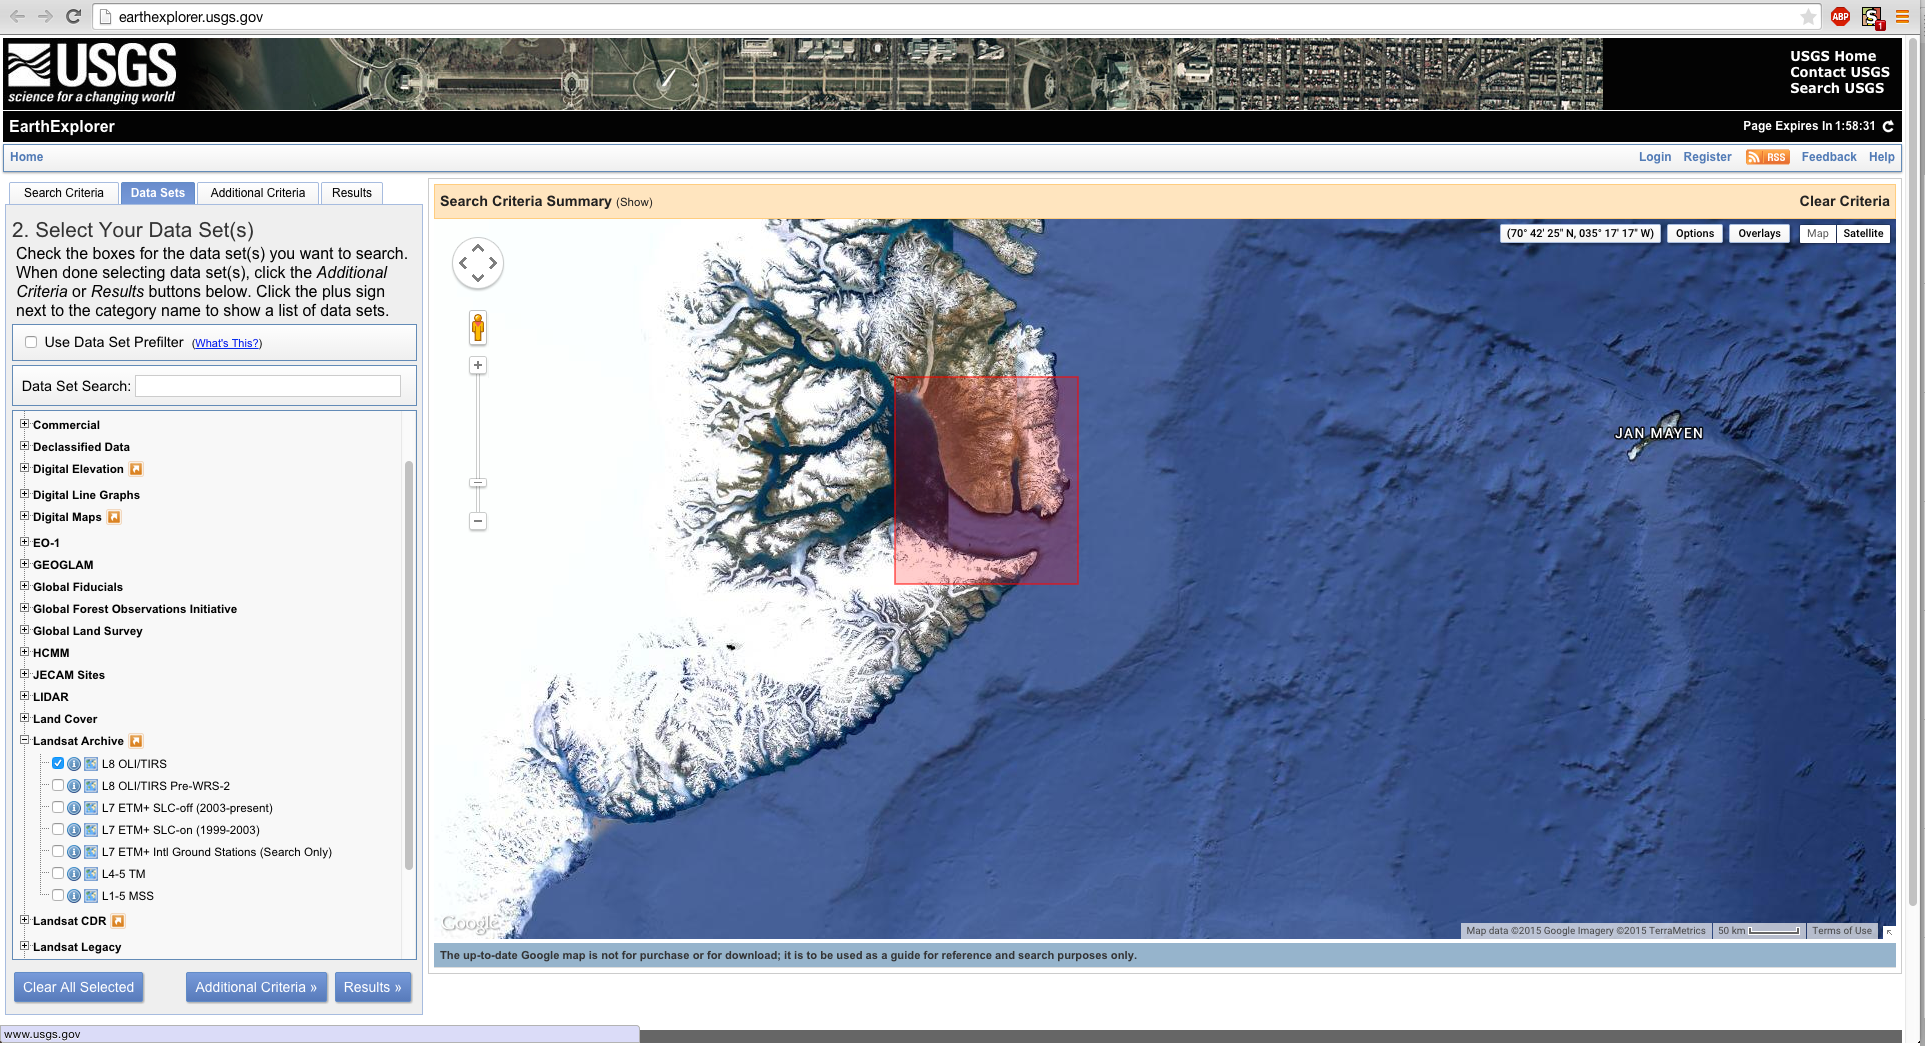

In [3]:
Image(filename="EarthExplorer.png")

Your first set of data will come from scene ID “LC82260102014232LGN00”, from a capture in August 2014. In the "Data Sets" view, expand "Landsat Archive" and then select "L8 OLI/TIRS". After clicking "Results", you will be presented with a list of scenes, each with a preview. You can click on the thumbnail image to see the preview. Once you have located the scene, click the tiny little "package" icon (it will be light brown/tan in color). If you haven't logged in, you will be prompted to. Add it to your cart, and then go to your cart to complete the free order. 

Next, you will need to open the BDA application and then download your order from there (when it opens, it will show you pending orders and present you with the option of downloading them).

## Pre-cloud: figuring out the workflow

Before creating a cloud workflow, we need to step through the process manually to identify all the steps and indicate which may be automated. We will be using a data set from a specific point in time, but what we define here should be usable by any Landsat 8 data – and some of it will be usable by older satellite remote sensing data.

We will start by organizing the data. The BDA will save its downloads to a specific location (different for each operating system); let's move all the data you've pulled down with the EarthExplorer BDA to a location we can easily reference in our IPython notebook: /EROSData/L8_OLI_TIRS. Ensure that your scene data is there, in the  LC82260102014232LGN00 directory.

### Organizing the data

In [4]:
path = "/EROSData/L8_OLI_TIRS"
scene_id = "LC82260102014232LGN00"

In [5]:
ls -al "/EROSData/L8_OLI_TIRS"

total 5119224
drwxr-xr-x   8 oubiwann  admin        272 Feb 18 16:47 ./
drwxr-xr-x   3 root      wheel        102 Mar  8 17:38 ../
-rw-r--r--@  1 oubiwann  admin       6148 Feb 18 16:47 .DS_Store
drwx------  15 oubiwann  admin        510 Feb 18 16:47 LC82260102014232LGN00/
-rw-r--r--   1 oubiwann  admin  870851424 Feb 18 16:23 LC82260102014232LGN00.tar.gz
-rw-r--r--   1 oubiwann  admin  987687037 Feb 18 16:19 LC82270102014255LGN00.tar.gz
drwx------  15 oubiwann  admin        510 Feb 18 13:15 LC82290092015048LGN00/
-rw-r--r--   1 oubiwann  admin  762490146 Feb 17 19:21 LC82290092015048LGN00.tar.gz


### Generating the images

In [6]:
rgb_image = eros.extract_rgb(path, scene_id)

If you examine the source for that function you will see that invokes a chain of tasks such as:
* identifying the files which are associated with the Landsat band data
* extracting them from the source data, and then
* creating a data structure to represent red, blue, and green channels needed for digital color images.

Landsat 8 records mulitple bands, only three of which are bands which cover the familiar channels (R, G, and B) which represent visible light. The Landsat 8 bands are as follows:

* Band 1: Deep blues and violets, useful for tracking coastal waters and fine particles in the air
* Band 2: Visible blue light
* Band 3: Visible green light
* Band 4: Visible red light
* Band 5: Near infrared, useful for viewing healthy plants
* Band 6 and 7: Shortwave infrared, useful for identifying wet and dry earth and showing contrast in rocks and soil
* Band 8: Panchromatic, like black and white film this band combines all colors; due to its sharp contrast and high resolution, it's useful for zoming in on details
* Band 9: A narrow slice of wavelenghts used by few space-based instruments; useful for examining cloud cover and very bright objects
* Band 10 and 11: Thermal infrared, useful for viewing the temperature of the air

In your task, you will be using bands 1 through 4 for water and RGB, 5 for vegetation, and 7 to pick out rocks. Let's take a look at the true-color RGB image for the bands we just extracted:

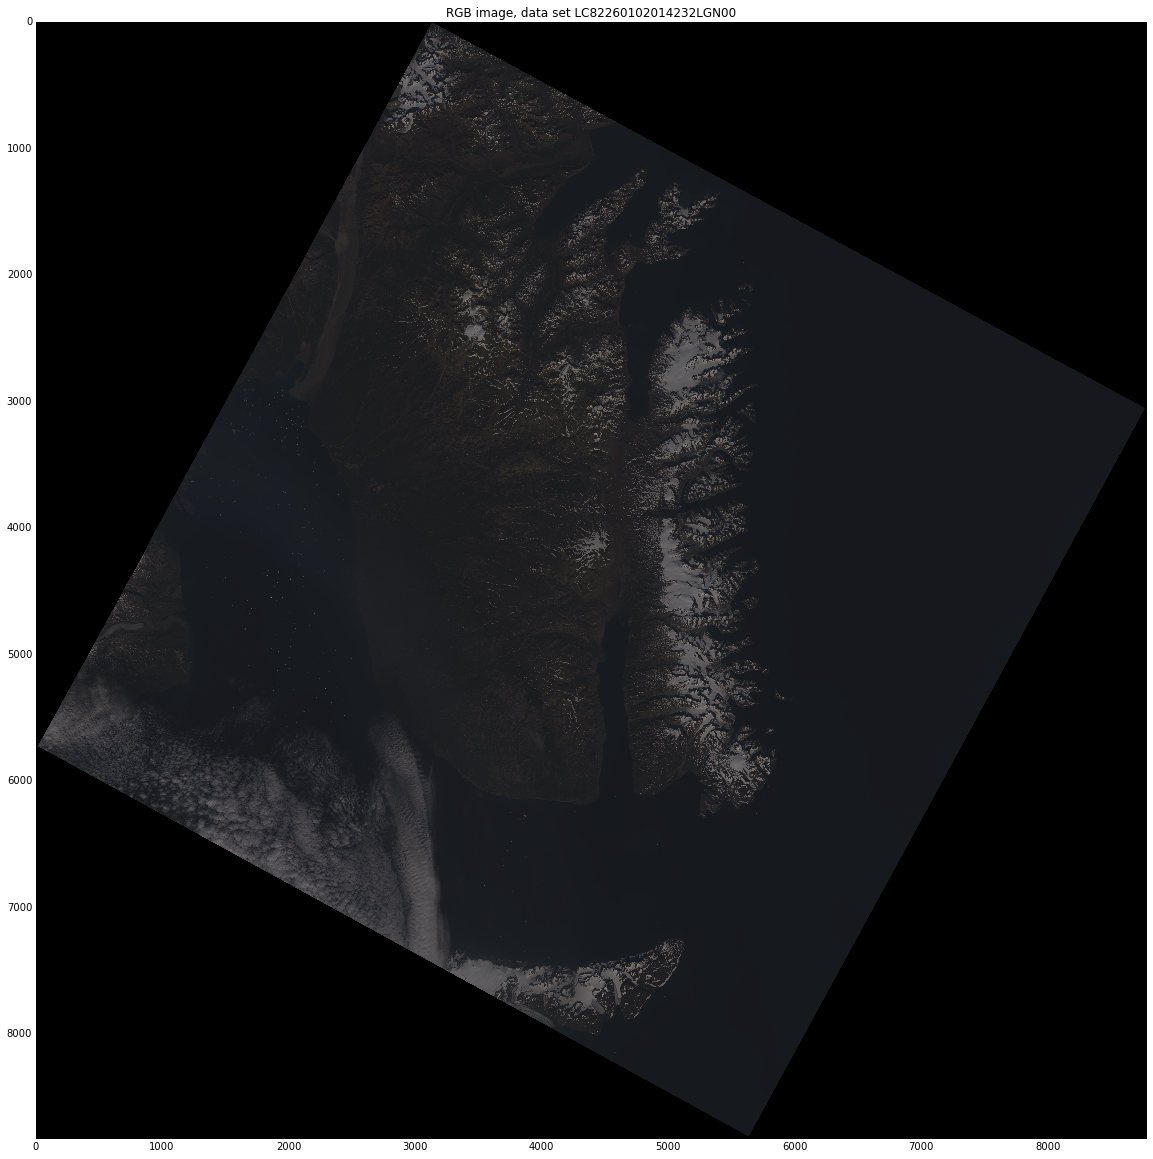

In [7]:
eros.show_image(rgb_image, "RGB image, data set " + scene_id, figsize=(20, 20))

That image isn't very clear – the colors are all quite muted. We can gain some insight into this by looking at a histogram of the data files for each color channel:

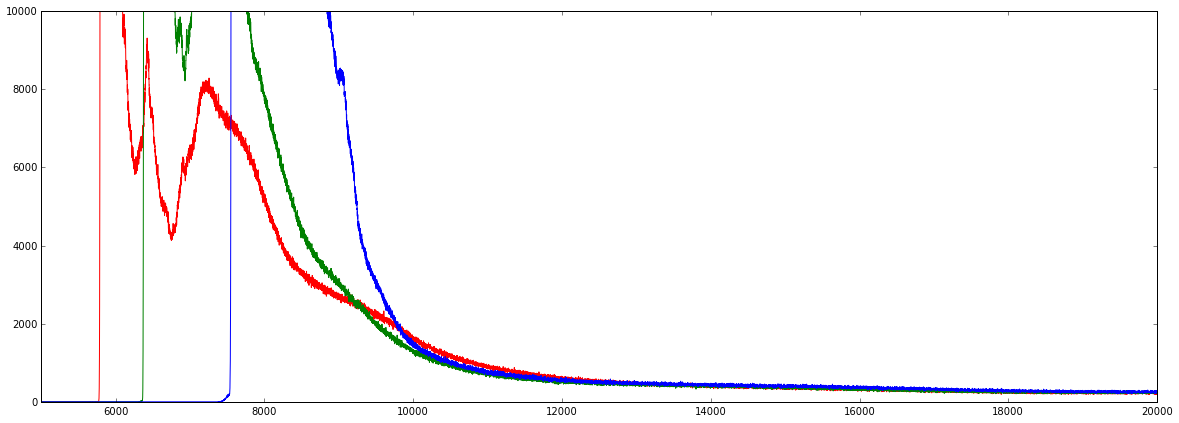

In [8]:
eros.show_color_hist(rgb_image, xlim=[5000,20000], ylim=[0,10000], figsize=(20, 7))

As we can see, the majority of the color information is concentrated in a narrower band, while the outlying data is still included. Let's create a new image, using ranges for the majority of the color data. We'll do this by visually estimating good cut-off points: we'll limit the red channel to the range 5900-11000, green to 6200-11000, and blue to 7600-11000:

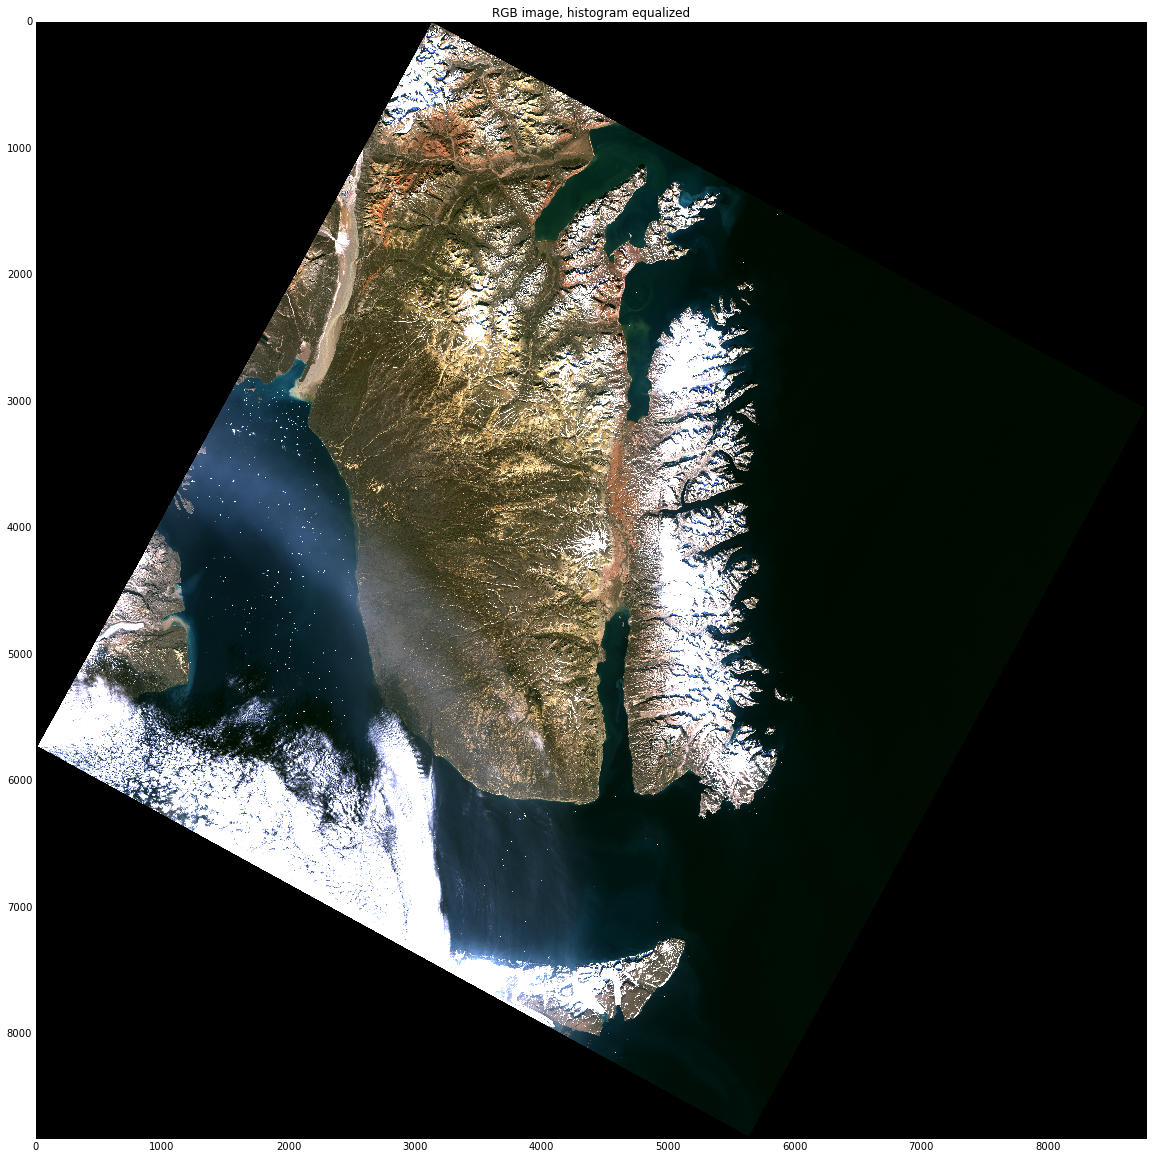

In [9]:
rgb_image_he = eros.update_image(rgb_image, (5900, 11000), (6200, 11000), (7600, 11000))
eros.show_image(rgb_image_he, "RGB image, histogram equalized", figsize=(20, 20))

The next image you've been asked to generate is is a false color one with the following taking the place of the standard RGB values:
 * In the "red" channel, use the data from the second short-wave infrared Landsat 8 band (rocks and bare earch will be more readily visible, showing up in redish hues)
 * In the "green" channel, use the data from the near-infraread Landsat 8 band (useful for showing plant life which reflect this frequency range)
 * In the "blue" channel, use the data from the coastal/aerosol Landsat 8 band (water and low-laying particles will be "deep" blue)
 
In this type of image, ice will show up as light blue/cyan.

We will perform the same process of:

1. Extracting raw image data
1. Examining the histogram
1. Rendering an image using the limits from our histogram

In [10]:
swir2nirg_image = eros.extract_swir2nirg(path, scene_id)

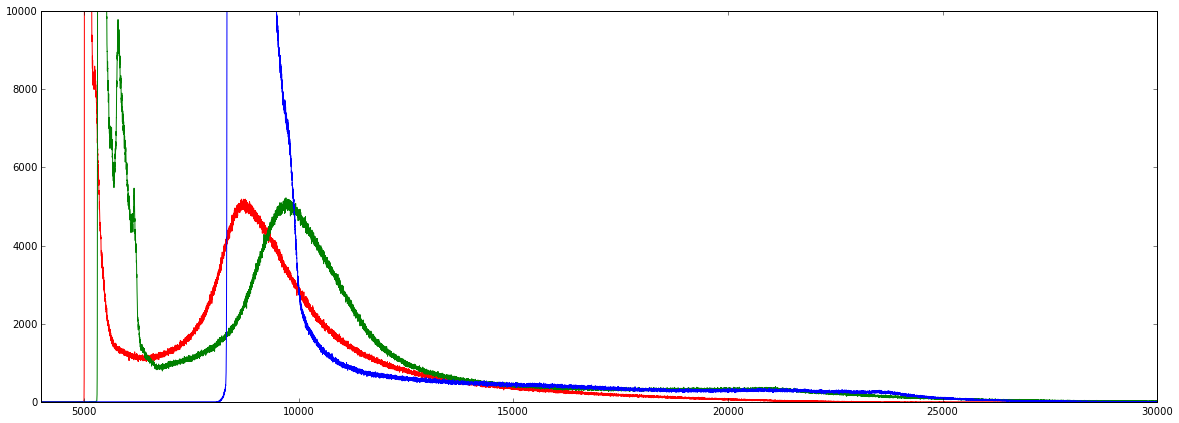

In [11]:
eros.show_color_hist(swir2nirg_image, xlim=[4000,30000], ylim=[0,10000], figsize=(20, 7))

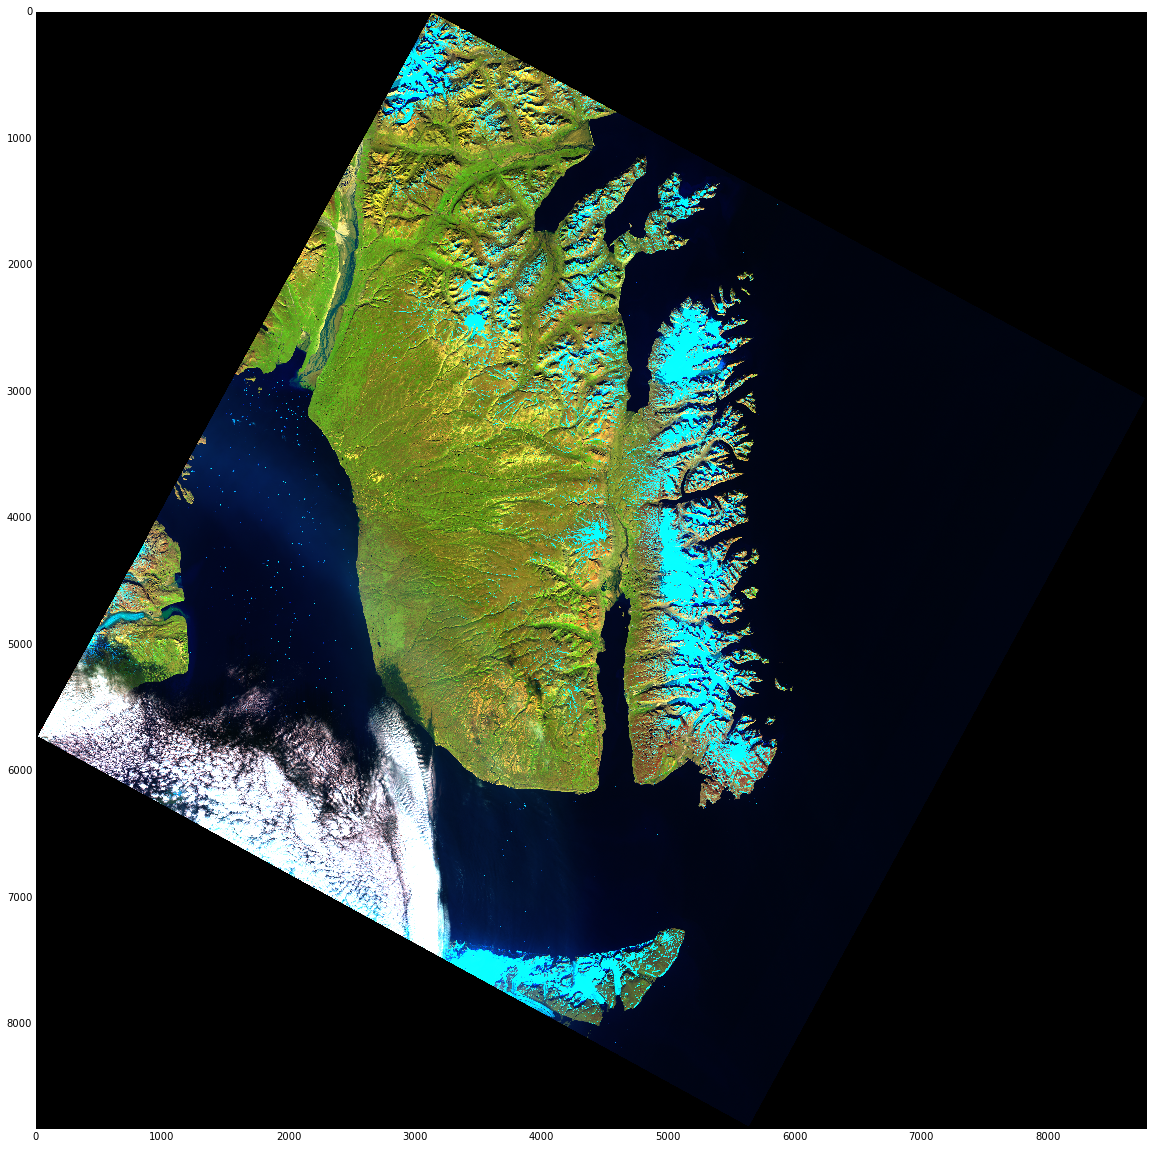

In [12]:
swir2nirg_image_he = eros.update_image(swir2nirg_image, (5000, 14000), (5200, 14000), (8000, 14000))
eros.show_image(swir2nirg_image_he, "", figsize=(20, 20))

On an 2009 iMac (Intel Core i7, 8GB RAM), processing both of those images took about 7 minutes total with the Python process consuming about 6GB of RAM. The IPython kernel needs to be restarted after 2 to 3 runs, due to memory consumption. This is a task well-suited to utility computing, that will free up your workstation while large numbers of these jobs can be executed quickly elsewhere.

### The identified workflow

You've now identified the steps needed to create the images for your project:

* Define a Landsat 8 scene ID
* Ensure the data is available (downloaded via the EarthExplorer BDA)
* Extract coastal/aerosol, RGB, near IR, and shortwave IR data from the uncompressed Landsat 8 data files
* Identify optimum ranges for display in each channel (we'll be skipping this when we automate; however, this is an excellent exercise for the motivated reader)
* Generate image files for the extracted data using your mini ``eros`` library

### Selecting technologies

In the process of clearly defining these steps, you've also shown that the resource utilization is high and takes a while on your workstation. As such, you know that jobs of any significant number or duration will need to be distributed across multiple machines, and this is a prime use case for cloud computing.

You've selected the AWS EC2 and S3 infrastructure for your cloud environment, but next need to identify what you will use to configure and run matplotlib plot-generation code. For configuration management you've looked at the following:

* Saltstack and Asnible are both Python 2.x only; you're in a Python 3 shop, so that's a no-starter.
* Chef and Puppet are world-class configuration management tools, but your needs are very simple.
* You've heard a lot about Docker and it provides capabilities along configuration management lines that suite your current needs.
 
After some reading and prototyping with the above potential solutions, you were able to get the furtherest with Docker in the shortest time and, more importantly, we able to confirm that Docker exactly suited your needs. Furthermore, your configuration mangament selction is also a prime virutalization choice for running emphemeral, compute-intensive jobs inside an EC2 instance.

### Planning for the next steps

So you've come up with a plan:

1. Create some Docker images (a base Python one, a SciPy one, and then one for your specific task -- this leaves you with the greatest future flexibility, and reduces build-times when you need to iterate on the Docker image for this particular task)
1. Deploy the Docker image in a cloud (Google, AWS, OpenStack and others support Docker images)
1. Fire up a Docker instance for every rendering you need to perform
1. Perform the necessary computations and save the images
1. Push the generated images to your file storage service (S3 in this case) and shutdown the Docker instance

The next steps are now clear:
 * Prepare your workstation and create the required Docker image
 * Copy the necessary files to S3
 * Prepare an EC2 instance for running your Docker instances
 * Run your jobs in Docker on EC2
 
Let's continue on!

## Getting set up at home

### Requirements

You will be creating your Docker images locally, so you will need the following installed on your workstation:

* Docker
* [boot2docker](http://boot2docker.io/) (for easily using Docker from Windows or Mac)

If you're running Linux, you can skip the rest of this section and just install Docker (the ``docker.io`` package on Ubuntu; just ``docker`` on RedHat-based systems).

If you haven't run ``boot2docker`` before, you'll need to do this first:

```bash
$ boot2docker init
```

If you have, you can just do this:

```bash
$ boot2docker up
```

At which point you will see output something like the following:

```
Waiting for VM and Docker daemon to start...
...............ooo
Started.
Writing /Users/oubiwann/.boot2docker/certs/boot2docker-vm/ca.pem
Writing /Users/oubiwann/.boot2docker/certs/boot2docker-vm/cert.pem
Writing /Users/oubiwann/.boot2docker/certs/boot2docker-vm/key.pem

To connect the Docker client to the Docker daemon, please set:
    export DOCKER_CERT_PATH=/Users/oubiwann/.boot2docker/certs/boot2docker-vm
    export DOCKER_TLS_VERIFY=1
    export DOCKER_HOST=tcp://192.168.59.103:2376
```

You can either manually export those environment variables, or do this:

```bash
$(boot2docker shellinit)
```

which will set the appropriate variables in your shell environment. At this point, Docker is ready to use!

### ``Dockerfile``s and Docker images

The heart of your configuration management work is the ``Dockerfile``. This will be used to generate the Docker image you need to run Docker containers -- where your matplotlib tasks will actually happen. If you are unfamiliar with Docker, here's a quick summary of how to think about these components:

* ``Dockerfile`` - the specification for building extendible images ([more info](https://docs.docker.com/reference/builder/))
* Docker image - a read-only template, somewhat like a filesystem ([more info](https://docs.docker.com/terms/image/))
* Docker container - an isolated and secure application platform -- this is what actually gets run ([more info](https://docs.docker.com/terms/container/))

But we will start at the beginning: ``Dockerfile``s. Here is our first ``Dockerfile``:

In [13]:
cat ../docker/python/Dockerfile

FROM ubuntu:vivid
MAINTAINER Duncan McGreggor <oubiwann@gmail.com>
ENV DEBIAN_FRONTEND noninteractive
RUN apt-get update
RUN apt-get upgrade -y
RUN apt-get install -y -q apt-utils
RUN apt-get install -y -q ca-certificates git build-essential
RUN apt-get install -y -q libssl-dev libcurl4-openssl-dev
RUN apt-get install -y -q curl
RUN apt-get install -y -q cython3 libpython3.4-dev python3.4-dev \
    python3-setuptools python3-pip
CMD python3


Note that it is *not* a ``Dockerfile`` which has been created from scratch; rather, it is based upon the official Ubuntu Vivid Vervet (15.04) image. An image has already been generated from this ``Dockerfile`` and has been pushed up to [Docker Hub](https://registry.hub.docker.com/repos/masteringmatplotlib/).

The next ``Dockerfile`` is for NumPy and SciPy dependencies:

In [14]:
cat ../docker/scipy/Dockerfile

FROM masteringmatplotlib/python
MAINTAINER Duncan McGreggor <oubiwann@gmail.com>
ENV DEBIAN_FRONTEND noninteractive
RUN apt-get install -y -q libatlas3-base libblas-dev libblas3 \
    libatlas-base-dev libatlas-dev liblapack-dev gfortran
ENV LAPACK /usr/lib/liblapack.so
ENV ATLAS /usr/lib/libatlas.so
ENV BLAS /usr/lib/libblas.so
RUN apt-get install -y -q python3-six python3-flake8 python3-dateutil \
    python3-pyparsing python3-numpy python3-scipy python3-matplotlib \
    python3-pandas
RUN pip3 install seaborn
CMD python3


As you can see, this ``Dockerfile`` extends our previous one, ``masteringmatplotlib/python `` by adding libraries we most commonly need when using Python for scientific computing. This one has also been pushed up to Docker Hub.

In the next section we will discuss how to create a new ``Dockerfile`` based upon this one.

### Extending a Docker image

#### Getting the base image

Since the base Docker images we want to use (the chain of ubuntu:vivid -> masteringmatplotlib/python -> masteringmatplotlib/scipy) have already been built and pushed to Docker Hub, there's no need for us to build them from scrath: we just need to download them. The top-most layer of our image stack is all we need to ask for, and we'll get the rest automatically: 

```
$ docker pull masteringmatplotlib/scipy
```

This may take awhile to run, depending upon your internet connection: you will be downloading pre-built Docker images, several hundred MB in total.

Once that is completed and to make sure things are working, we can start it up and run the image's default command (``python3`` in this case):

```
$ docker run -t -i masteringmatplotlib/scipy
```

You should be greated with the familiar prompt; try an ``import`` as a sanity check:

```python
>>> import matplotlib
>>>
```

You can exit out of the Docker container by quiting the Python interpreter:

```python
>>> ^d
```

#### Customizing your ``Dockerfile``

We've got our scipystack Docker image downloaded and usable. How do we customize it?

There are two ways we could do it:
1. Make changes to the image and commit those, or
1. Create a Dockerfile that uses the image.

Let's go with option #2. To make it even easier, we've provided this file for you as part of this notebook:


In [15]:
cat ../docker/simple/Dockerfile

FROM masteringmatplotlib/scipy
MAINTAINER Py3 Hacker <you@py.hacker>
ENV HOME /root
ENV REPO cloud-deploy
RUN cd $HOME && \
    git clone https://github.com/masteringmatplotlib/${REPO}.git
RUN cd $HOME/$REPO && \
    make docker-setup
CMD PYTHONPATH=${HOME}/${REPO}/lib:$PYTHONPATH python3


Points to note:
 * This ``Dockerfile`` extends the ``masteringmatplotlib/scipy `` Docker image
 * For ease of demonstration purposes, we're going to simply use the notebook repository and add it to ``PYTHONPATH``; in most situations, you'll want to created a ``setup.py`` for your Python library, install it with ``pip`` in the ``Dockerfile`` build steps, and then not have to mess with ``PYTHONPATH``.

### Building a new image

Let's build our new image!

```bash
$ docker build -f yourname/eros ./docker/simple/Dockerfile
```

After which you should see output like this:

```
Sending build context to Docker daemon  2.56 kB
Sending build context to Docker daemon
Step 0 : FROM ipython/scipystack
 ---> 113395173d25
Step 1 : MAINTAINER Py Hacker <you@py.hacker>
 ---> Using cache
 ---> fd520c92b33b

[snip]

Removing intermediate container 90983e9fdd54
Step 6 : CMD PYTHONPATH=./cloud-deploy/lib:$PYTHONPATH python3
 ---> Running in b7a022f2ac29
 ---> abde2bb0eeaa
Removing intermediate container b7a022f2ac29
Successfully built abde2bb0eeaa
```

Let's make sure our library is present in our new image:

```bash
docker run -t -i yourname/projname python3
```
```python
>>> import eros
>>> ^d
$
```

We've still got some more work to do, though.

### Preparing for deployment

We need two make a couple of changes from our simple case so that:
 * our code will know it's being called from Docker (used to set the backend to something which doesn't require a ``DISPLAY``), and
 * we can execute a "dispatch" function which will generate the desired type of satellite image.
 
These can both be accomplished simply by changing our Docker ``CMD`` directive:

In [16]:
cat ../docker/eros/Dockerfile

FROM masteringmatplotlib/scipy
MAINTAINER Py3 Hacker <you@py.hacker>
ENV HOME /root
ENV REPO cloud-deploy
RUN cd $HOME && \
    git clone https://github.com/masteringmatplotlib/${REPO}.git
RUN cd $HOME/$REPO && \
    make docker-setup
CMD DOCKER_CONTAINER=true \
    PYTHONPATH=${HOME}/${REPO}/lib:$PYTHONPATH \
    python3 -c "import ec2s3eros;ec2s3eros.s3_generate_image();"


The ``s3_generate_image`` function is the "dispatcher", and depending upon the environment variables which are set when running Docker, it will take different actions. More on that later.

## Getting set up on AWS

### Pushing source data to S3

The files we're working with are sizable, ranging from about 150MB to 600MB each. As such, we want to be selective in what we'll be pushing to S3. For your project, the following Landsat bands are needed:
 * red, green, and blue (bands 4, 3, and 2)
 * shortwave infrared, 2100-2300 nm (band 7)
 * near infrared 845-885 nm (band 5)
 
All the files for a particular scene weigh in at over 2GB, so we'll just want to push the files for the bands we need, per the Landsat bands noted above:
 * ``"$SCENE_PATH"/$SCENE/*_B[1-5,7].TIF``
 
Before running the commands below, you need to make sure that the user associated with the access and secret keys have appropriate S3 permissions (e.g., the ability to upload files). Let's start by setting some shell variables:
 
```bash
$ SCENE_PATH="/EROSData/L8_OLI_TIRS"
$ SCENE=LC82260102014232LGN00
$ export AWS_ACCESS_KEY_ID=YOURACCESSKEY
$ export AWS_SECRET_ACCESS_KEY=YOURSECRETKEY
```

Now we can create the S3 bucket:

```bash
$ aws s3 mb s3://scoresbysund
```

And with the bucket now existing, we can upload our particular Landsat scene files:

```bash
$ for FILE in "$SCENE_PATH"/$SCENE/*_B[2-5,7].TIF; do
    aws s3 cp "$FILE" s3://scoresbysund
  done
```

### Creating a server on EC2

Through trial and error, you have discovered that an ``m3/xlarge`` EC2 instance will be necessary, due to the intensive memory requirements for the image processing (the next step down was 7.5GB RAM, which was insufficient).

1. Log in to the AWS console and click the "Launch Instance" button.
1. Select your preferred "Volume Type" (e.g., Red Hat, SUSE, Ubuntu, etc.); we will be using an Ubuntu 64 EC2 AMI with 4 virtual CPUs and 15GB of RAM.
1. Select or create the "Security Group" that will allow in-bound SSH access to the EC2 instance from your workstation.
1. Launch!

Once the instance is up and running, get the IP address from the AWS Console where you launched it, and use that to SSH into it:

```bash
$ ssh -i /path/to/your-ec2-key-pair.pem ubuntu@instance-ip-address
```

Then, on the running instance, prep the instance by installing Docker and saving your AWS credentials (for access to S3) on the filesystem:

```bash
ubuntu@ip-address:~$ sudo apt-get install -y docker.io
ubuntu@ip-address:~$ sudo mkdir /etc/aws
ubuntu@ip-address:~$ sudo vi /etc/aws/access
ubuntu@ip-address:~$ sudo vi /etc/aws/secret
ubuntu@ip-address:~$ sudo chmod 600 /etc/aws/*
ubuntu@ip-address:~$ sudo chown ubuntu /etc/aws/*
```


### Using Docker on EC2

Now you need to pull down the Docker image we've created for this task, and then run a container using this image in interactive mode using Python as the shell. You can use the Docker image you created, or the one that we did (``masteringmatplotlib/eros``):

```bash
ubuntu@ip-address:~$ sudo docker run -i -t masteringmatplotlib/eros python3
Python 3.4.3 (default, Feb 27 2015, 02:35:54)
[GCC 4.9.2] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>>
```

A quick test to make sure everthing is in place:

```python
>>> import eros
>>>
```

If you get no errors, you're all set for the next steps!

### Reading and writing with S3

In order to read your scene data from the files that you uploaded to S3, you'll need to do the following:
 * Update your bucket permissions with a policy that allows your EC2 instance to access it.
 * Obtain the HTTP URL for your bucket on the S3 screen in the AWS Console.
 * Have the IP address of your newly-started EC2 instance handy.

S3 section in the AWS Console, go to bucket, highlight it, click "Properties", click "Edit bucket policy", in the form that appears, paste the following, substituting your EC2 IP address:

```json
{
    "Version": "2012-10-17",
    "Id": "S3ScoresbySundGetPolicy",
    "Statement": [
        {
            "Sid": "IPAllow",
            "Effect": "Allow",
            "Principal": "*",
            "Action": "s3:*",
            "Resource": "arn:aws:s3:::scoresbysund/*",
            "Condition" : {
                "IpAddress" : {
                    "aws:SourceIp": "YOUREC2IPADDRESS/32" 
                }
            } 
        } 
    ]
}
```

## Running the task

### Using environment variables

In the section above -- "Preparing for deployment" -- we mentioned an ``s3_generate_image`` function in our ``Dockerfile`` saying that it was the "dispatcher", and depending upon the environment variables which are set when running Docker, it would take different actions. We're going to cover that now.

When our EC2 instance starts up a Docker container tasked with building our Landsat 8 image files, the Docker container will need to know a few things:
 * The Landsat 8 scene id
 * The AWS access key to use for accessing S3 (where it will save the image files)
 * The AWS secret key to use for accessing S3 (where it will save the image files)
 
We can pass this information to the Docker container using the ``-e`` flag, which will set environment variabes in the container. Let's try this out and confirm this feature does what we need:

```bash
ubuntu@ip-address:~$ sudo docker run -i \
  -e "PYTHONPATH=/root/cloud-deploy" \
  -e "EROS_SCENE_ID=LC82260102014232LGN00" \
  -e "AWS_ACCESS_KEY_ID=`cat /etc/aws/access`" \
  -e "AWS_SECRET_ACCESS_KEY=`cat /etc/aws/secret`" \
  -t masteringmatplotlib/eros \
  python3
```

This will drop us into a Python prompt in the container where we can check on the environment variables:

```python
>>> import os
>>> os.getenv("EROS_SCENE_ID")
'LC82260102014232LGN00'
>>> os.getenv("AWS_ACCESS_KEY_ID")
'YOURACCESSKEY'
>>> os.getenv("AWS_SECRET_ACCESS_KEY")
'YOURSECRETACCESSKEY'
```

Now that you've confirmed that you can get the data you need into your Docker containers, you can update your code to check for particular ones that you will set when running a container to generate satellite images. For instance, towards the beginning of the ``lib/ec2s3eros.py`` module, we have the following:

```python
bucket_name = os.environ.get("S3_BUCKET_NAME")
scene_id = os.environ.get("EROS_SCENE_ID")
s3_path = os.environ.get("S3_PATH")
s3_title = os.environ.get("S3_IMAGE_TITLE")
s3_filename = os.environ.get("S3_IMAGE_FILENAME")
s3_image_type = os.environ.get("S3_IMAGE_TYPE", "").lower()
access_key = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
```

These are what our code will use inside our various S3-ized image generation functions. These parameters will allow us to create the appropriate image and save it to the appropriate place with the expected name.

### Updating the image and EC2

Let's now create a final (and updated) version of our Docker image:

```bash
$ docker build -t masteringmatplotlib/eros docker/eros/
```

Next, we'll need to publish it to Docker Hub so that you can pull it down on your EC2 instance:

```bash
$ docker push <your-project-or-user-name>/eros
```

One your EC2 instance, get the latest version of ``<your-project-or-user-name>/eros`` which you just published:

```bash
ubuntu@ip-address:~$ sudo docker pull <your-project-or-user-name>/eros
```

### Execution

Now you can *finally* run a Docker container from your image, thus generating a file for the RGB satellite image data:

```bash
ubuntu@ip-address:~$ export BUCKET=scoresbysund
ubuntu@ip-address:~$ export SCENE=LC82260102014232LGN00
ubuntu@ip-address:~$ export IMGTYPE=rgb
ubuntu@ip-address:~$ sudo docker run \
  -e "S3_IMAGE_TITLE=RGB Image: Scene $SCENE" \
  -e "S3_IMAGE_TYPE=$IMGTYPE" \
  -e "S3_IMAGE_FILENAME=$SCENE-$IMGTYPE-`date "+%Y%m%d%H%M%S"`.png" \
  -e "S3_BUCKET_NAME=$BUCKET" \
  -e "S3_PATH=https://s3-us-west-2.amazonaws.com/$BUCKET" \
  -e "EROS_SCENE_ID=$SCENE" \
  -e "AWS_ACCESS_KEY_ID=`cat /etc/aws/access`" \
  -e "AWS_SECRET_ACCESS_KEY=`cat /etc/aws/secret`" \
  -t masteringmatplotlib/eros
```

As that task runs, you will see output like the following:

```bash
Generating scene image ...
Saving image to S3 ...
0.0/100
27.499622350156933/100
54.99924470031387/100
82.4988670504708/100
100.0/100
```

On a relatively modern iMac, this job took about 7 to 8 minutes; on EC2 it only took about 15 seconds.

For the false-color short-wave and IR image, run a similar command:
```bash
ubuntu@ip-address:~$ export IMGTYPE=swir2nirg
ubuntu@ip-address:~$ sudo docker run \
  -e "S3_IMAGE_TITLE=False-Color Image: Scene $SCENE" \
  -e "S3_IMAGE_TYPE=$IMGTYPE" \
  -e "S3_IMAGE_FILENAME=$SCENE-$IMGTYPE-`date "+%Y%m%d%H%M%S"`.png" \
  -e "S3_BUCKET_NAME=$BUCKET" \
  -e "S3_PATH=https://s3-us-west-2.amazonaws.com/$BUCKET" \
  -e "EROS_SCENE_ID=$SCENE" \
  -e "AWS_ACCESS_KEY_ID=`cat /etc/aws/access`" \
  -e "AWS_SECRET_ACCESS_KEY=`cat /etc/aws/secret`" \
  -t masteringmatplotlib/eros
```
```bash
Generating scene image ...
Saving image to S3 ...
0.0/100
26.05542715379233/100
52.11085430758466/100
78.16628146137698/100
100.0/100
```

You can confirm that the image has been saved to your bucket by refreshing the S3 screen in your AWS Console.

Though it may seem awkward to parameterize the Docker container with so many environment variables, this allows you to easily change the data you pass without needing to re-generate the Docker image. Your Docker image produces containers that are generally useful for the task at hand, allowing you to process any scene.